# Проект: Принятие решений в бизнесе

Наш заказчик — крупный интернет-магазин. Вместе с отделом маркетинга мы подготовили список из девяти гипотез для увеличения выручки.
Нам необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. 

Таким образом исследование пройдет в четыре этапа:
1. Знакомство с данными и предобработка.
2. Приоритизация гипотез:
- применение фреймворка `ICE`;
- применение фреймворка `RICE`.
3. Анализ A/B-теста:
- построение графика кумулятивной выручки по группам;
- построение графика кумулятивного среднего чека по группам;
- построение графика относительного изменения кумулятивного среднего чека группы B к группе A;
- построение графика кумулятивного среднего количества заказов на посетителя по группам;
- построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A;
- построение точечного графика количества заказов по пользователям;
- определение аномальных пользователей;
- построение точечного графика стоимостей заказов;
- определение аномальных заказов;
- расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным;
- расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным;
- расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным;
- расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.
4. Оформление общих выводов и принятие решения по результатам теста.

### Знакомство с данными и предобработка

In [1]:
# импортируем библиотеки, которые нам пондобятся для работы
from scipy import stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
try:
    hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),  # гипотезы
        pd.read_csv('/datasets/orders.csv'),  # заказы
        pd.read_csv('/datasets/visitors.csv')  # посетители
    )

except FileNotFoundError:
    hypothesis, orders, visitors = (
        pd.read_csv(r'D:\datasets\ab_test\hypothesis.csv'),  # гипотезы
        pd.read_csv(r'D:\datasets\ab_test\orders.csv'),  # заказы
        pd.read_csv(r'D:\datasets\ab_test\visitors.csv')  # посетители
    )

**Описание данных**

Файл `/datasets/hypothesis.csv`.
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл `/datasets/orders.csv`.
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv`.
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

In [3]:
# посмотрим общую информацию по каждому датафрейму
for i in [hypothesis, orders, visitors]:
    display(i.info())
    display(i.head(9))
    print('Количество явных дубликатиов:', i.duplicated().sum())
    print(75 * '_', end='\n\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Количество явных дубликатиов: 0
___________________________________________________________________________


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A


Количество явных дубликатиов: 0
___________________________________________________________________________


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617


Количество явных дубликатиов: 0
___________________________________________________________________________




Названия столбцов в датафреймах *hypothesis* и *orders* не приведены к "змеиному" регистру, исправим это.\
Также видим, что в датафреймах *orders* и *visitors* у значений в столбцах с датой/временем тип данных `object`, поменям на `datetime64`.\
Пропуски и явные дубликаты не обнаружены.

In [4]:
# приведем названия столбцов к "змеиному" регистру
for i in [hypothesis, orders]:
    i.columns = i.columns.str.replace('Id', '_id').str.lower()

In [5]:
# преобразование данных о времени
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

In [6]:
# проверим на наличие отрицательных и нулевых (аномальных) значений в суммах выручки заказов и в количестве посетителей по датам
print('Количество аномальных значений в суммах выручки заказов:', len(orders.query('revenue <= 0')))
print('Количество аномальных значений в количестве посетителей:', len(visitors.query('visitors <= 0')))

Количество аномальных значений в суммах выручки заказов: 0
Количество аномальных значений в количестве посетителей: 0


In [7]:
# посмотрим на размер групп
groups_sizes = orders.groupby('group').agg({'visitor_id': 'nunique'})
groups_sizes['ratio, %'] = round(groups_sizes['visitor_id'] / groups_sizes['visitor_id'].sum() * 100, 2)
groups_sizes

,visitor_id,"ratio, %"
group,,
A,503,46.19
B,586,53.81


Группа А немного меньше группы В. Разница в размерах групп, возможно, обусловлена тем, что в группе В лучше конверсия (выясним это в ходе исследования). Разница не существенна, это не должно сильно повлиять на результаты теста.\
Теперь проверим есть ли пересечения id пользователей в обеих группах.

In [8]:
# напишем функцию, которая вернет список пересекающихся visitor_id
def get_intersection_of_visitor_ids(df1, df2):
    
    # получим множество visitor_id в каждом датафрейме
    visitor_ids_1 = set(df1['visitor_id'])
    visitor_ids_2 = set(df2['visitor_id'])

    # пересечение двух множеств
    intersection = visitor_ids_1 & visitor_ids_2

    return list(intersection)

In [9]:
# разделим датафрейм orders по группам
orders_a = orders.query('group == "A"')
orders_b = orders.query('group == "B"')

In [10]:
intersection = get_intersection_of_visitor_ids(orders_a, orders_b)
print('Количество пересекающихся пользователей в двух группах:', len(intersection))

Количество пересекающихся пользователей в двух группах: 58


Видим, что имеется 58 пользователей, которые находятся одновременно в обеих группах, хотя попавший в одну из групп посетитель должен оставаться в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.\
Во избежание искажения результатов, уберемем пересекающихся пользователей из таблицы *orders*.

In [11]:
# уберем пересекающихся пользователей из обеих групп
orders = orders.query('visitor_id not in @intersection').reset_index()
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   index           1016 non-null   int64         
 1   transaction_id  1016 non-null   int64         
 2   visitor_id      1016 non-null   int64         
 3   date            1016 non-null   datetime64[ns]
 4   revenue         1016 non-null   int64         
 5   group           1016 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 47.8+ KB


In [12]:
# посмотрим на даты начала и окончания теста
start_date = orders['date'].min()
end_date = orders['date'].max()
print('Тест начался:', start_date.date())
print('Тест завершился:', end_date.date())

Тест начался: 2019-08-01
Тест завершился: 2019-08-31


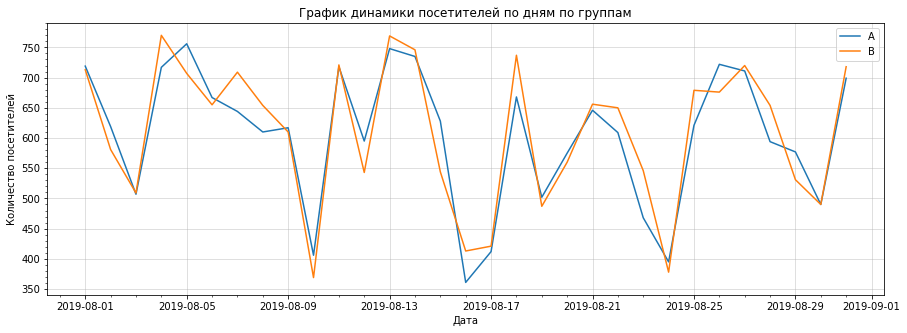

In [13]:
# посмотрим динамику посетителей по дням по группам
visitors_a = visitors.query('group == "A"')
visitors_b = visitors.query('group == "B"')

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(visitors_a['date'], visitors_a['visitors'], label='A')
ax.plot(visitors_b['date'], visitors_b['visitors'], label='B')
plt.legend()
plt.minorticks_on()
plt.xlabel('Дата')
plt.ylabel('Количество посетителей')
plt.grid(alpha=0.5)
plt.title('График динамики посетителей по дням по группам');

По графикам видно, что количество посетителей по дням в обеих группах примерно одинаковое. Наблюдаются резкие "скачки" количества посетителей с примерно недельными интервалами, по всей видимости связанные с проводимыми мероприятиями по привлечению пользователей.

**Выводы по предобработке данных**

Мы загрузили данные из предоставленных csv-файлов. Пропусков, явных дубликатов и каких-либо явных аномалий в данных обнаружено не было, однако, были обнаружены пользователи, которые присутствовали одновременно в двух группах. Во избежание искажения результатов, пересекающиеся пользователи из выборки были исключены.\
Для удобства анализа мы привели названия столбцов к "змеиному" регистру, а также у значений в столбцах с датой/временем тип данных поменяли на `datetime64`.\
Можем переходить к анализу не опасаясь "подводных камней".

### Приоритизация гипотез
#### Фреймворк ICE для приоритизации гипотез

**ICE** (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота») — один из самых популярных способов приоритизации задач, рассчитывается по формуле:

<div>
<br>
$ICE = \frac{Impact * Confidence}{Efforts}$
</div>

In [14]:
# применим фреймворк ICE для приоритизации гипотез и отсортируем их по убыванию приоритета
pd.options.display.max_colwidth = 130
hypothesis['ICE'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2)
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


#### Фреймворк RICE для приоритизации гипотез

У метода **ICE** есть модификация **RICE** (R от англ. reach, «охват»), рассчитывается по формуле:

<div>
<br>
$RICE = \frac{Reach * Impact * Confidence}{Efforts}$
</div>

In [15]:
# применим фреймворк RICE для приоритизации гипотез и отсортируем их по убыванию приоритета
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Выводы по приоритизации гипотез**

В результате применения фреймворка **ICE** наиболее приоритетной выглядела гипотеза `"Запустить акцию, дающую скидку на товар в день рождения"`, однако, после применения фреймворка **RICE** данная гипотеза перешла в середину списка, оказавшись лишь на *пятом* месте, а на первое место в свою очередь вышла гипотеза `"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"`.\
Это произошло в результате того, что в фреймворке **RICE** добавляется параметр *Reach (охват)*, а он у гипотезы `"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"` равен **10**, т.е. затрагивает максимальное количество пользователей, в то время как у гипотезы `"Запустить акцию, дающую скидку на товар в день рождения"` этот параметр равен лишь **1**, что говорит о том, что одномоментно такое изменение коснется незначительного количества пользователей.\
В связи с вышеизложенным выбираем гипотезу `"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"` как приоритетную.

### Анализ A/B-теста
#### Построение графика кумулятивной выручки по группам

Построим графики кумулятивной выручки по дням и группам A/B-тестирования.

In [16]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# получаем агрегированные кумулятивные по дням данные о посетителях
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

In [17]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [18]:
# проверим совпадают ли минимальная и максимальная даты в этом датафрейме 
# с минимальной и максимальной датой в исходных данных
if cumulativeData['date'].min() == start_date and cumulativeData['date'].max() == end_date:
    print('Даты начала и окончания теста совпадают, можем продолжать.')
else:
    print('Что-то не так, где-то ошибка :(')

Даты начала и окончания теста совпадают, можем продолжать.


In [19]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

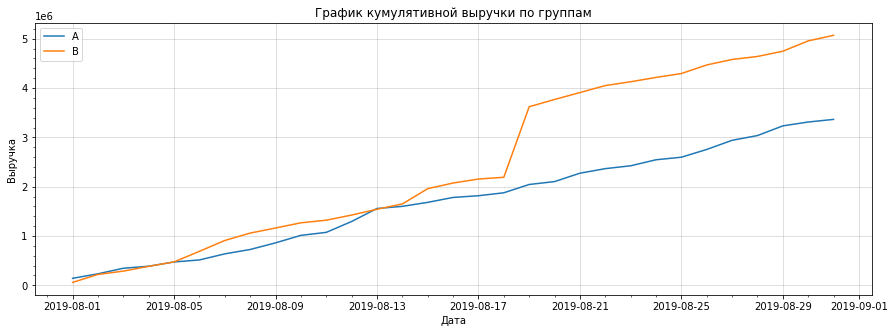

In [20]:
# строим графики
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
ax.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
ax.minorticks_on()
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.grid(alpha=0.5)
plt.legend()
plt.title('График кумулятивной выручки по группам')
plt.show();

Выручка почти равномерно увеличивается на протяжении всего теста, однако график выручки группы B в районе 18 августа резко растет. Это может сигнализировать о всплеске числа заказов, либо о появлении очень дорогих заказов в выборке.

#### Построение графика кумулятивного среднего чека по группам

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов.

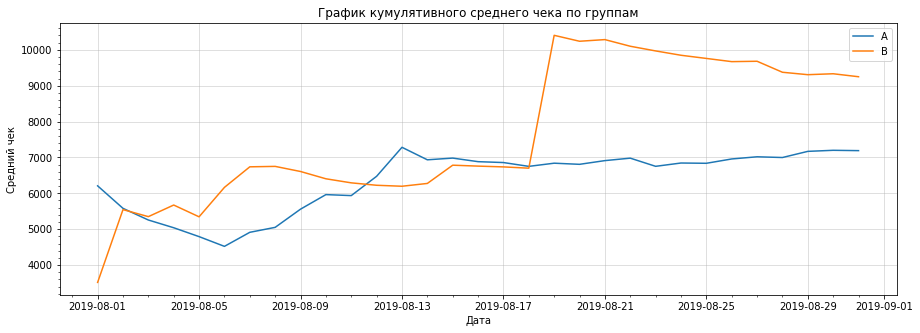

In [21]:
# строим графики
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
ax.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
ax.minorticks_on()
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.grid(alpha=0.5)
plt.legend()
plt.title('График кумулятивного среднего чека по группам')
plt.show();

Для группы А в первую неделю августа видим постепенное снижение среднего чека, после чего равномерный рост до 13 августа, затем график стабилизируется.\
Для группы В средний чек в первую неделю августа растет резкими рывками, после чего стабилизируется, и, снова 18 августа видим очень резкий скачок, скорее всего связанный с дорогостоящими заказами. Затем видно снижение, но скорее всего это искажение из-за зафиксированного "выброса".

#### Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

Построим график относительного различия для среднего чека.

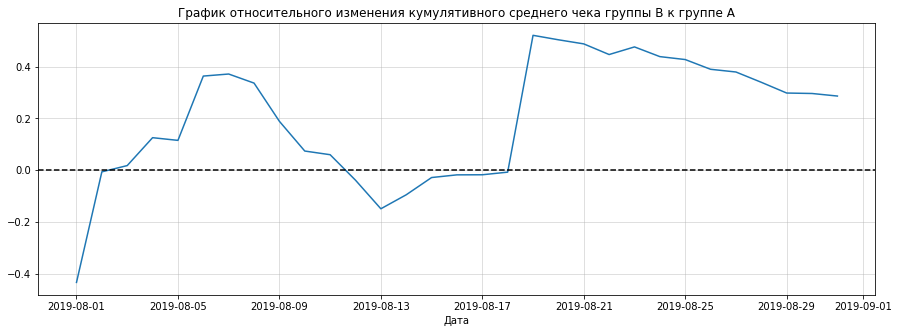

In [22]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
fig = plt.figure(figsize=(15, 5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/\
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA']) - 1)
plt.xlabel('Дата')
plt.grid(alpha=0.5)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--');

В нескольких точках график различия между сегментами резко «скачет». Опять же, скорее всего в эти дни были крупные заказы и выбросы.

#### Построение графика кумулятивного среднего количества заказов на посетителя по группам

Аналогично проанализируем график кумулятивной конверсии. 

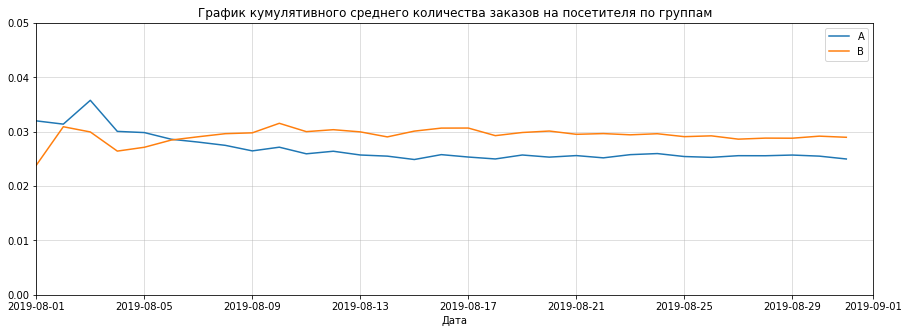

In [23]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
ax.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xlabel('Дата')
plt.grid(alpha=0.5)
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05]);

В первую неделю теста группа А имела большую конверсию, но постепенно группа В выровнялась и зафиксировалась примерно около одного значения больше значения А.

#### Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

Построим график относительного различия кумулятивных конверсий.

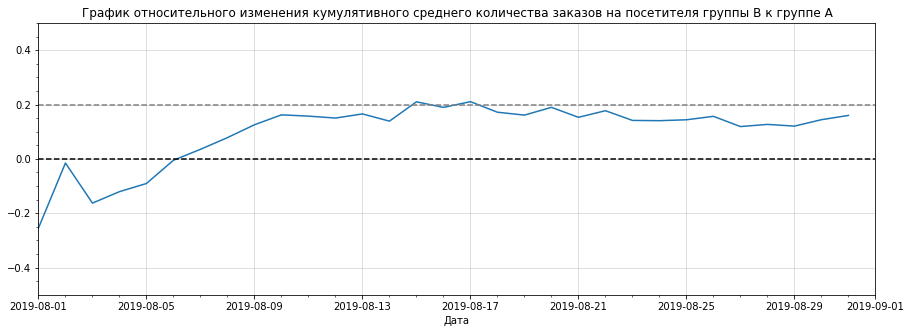

In [24]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
fig = plt.figure(figsize=(15, 5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/\
         mergedCumulativeConversions['conversionA'] - 1)
plt.minorticks_on()
plt.xlabel('Дата')
plt.grid(alpha=0.5)
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.5, 0.5]);

Практически на протяжении всего теста конверсия группы В стабильно лучше, чем у группы А: середине августа прирост был достигнут прирост около 20%, однако, к концу месяца немного снизился.

#### Построение точечного графика количества заказов по пользователям

Подсчитаем количество заказов по пользователям.

In [25]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['visitor_id', 'orders']
print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

     visitor_id  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


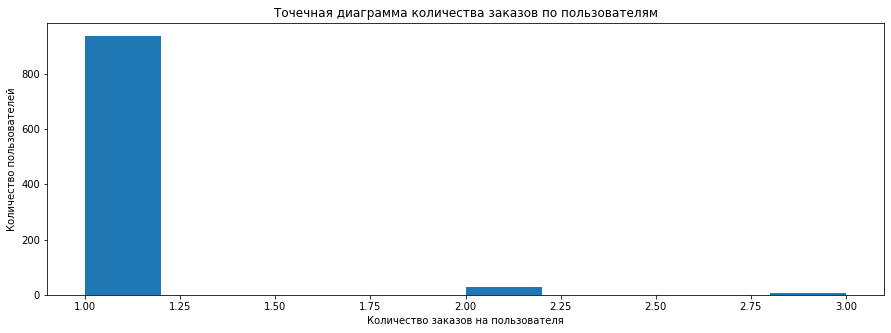

In [26]:
# строим гистограмму распределения числа заказов по пользователям
fig = plt.figure(figsize=(15, 5))
plt.hist(ordersByUsers['orders'])
plt.xlabel('Количество заказов на пользователя')
plt.ylabel('Количество пользователей')
plt.title('Точечная диаграмма количества заказов по пользователям');

Большинство покупателей совершили только один заказ.\
Построим точечную диаграмму числа заказов на одного пользователя.

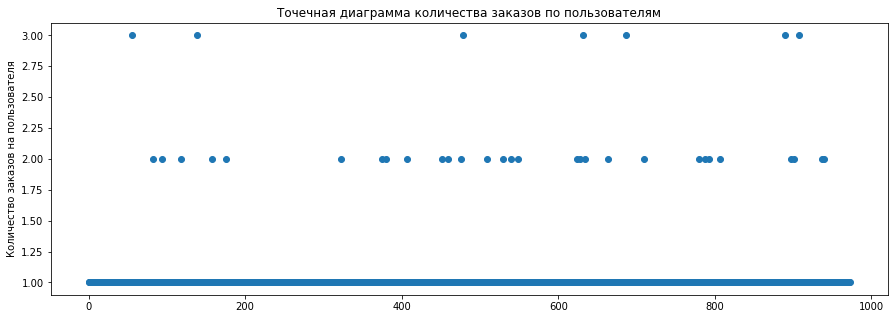

In [27]:
fig = plt.figure(figsize=(15, 5))
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.ylabel('Количество заказов на пользователя')
plt.title('Точечная диаграмма количества заказов по пользователям')
plt.show()

Пользователей, заказавших более одного раза не так много и они вполне могут быть аномалными.

#### Определение аномальных пользователей

Посчитаем выборочные перцентили количества заказов на одного пользователя.

In [28]:
ordersByUsers['orders'].describe(percentiles=[0.95, 0.99])

count    973.000000
mean       1.044193
std        0.238090
min        1.000000
50%        1.000000
95%        1.000000
99%        2.000000
max        3.000000
Name: orders, dtype: float64

Не более 5% пользователей совершали более одного заказа и не более 1% - больше двух заказов.\
Будем считать аномальными пользователей, совершивших более двух заказов.

#### Построение точечного графика стоимостей заказов

Построим точечную диаграмму стоимостей заказов.

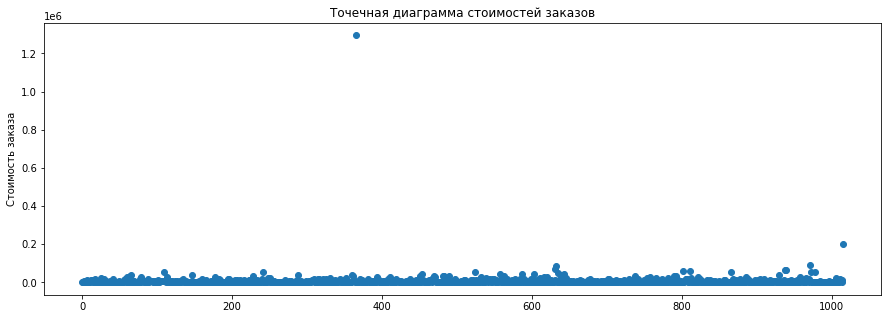

In [29]:
fig = plt.figure(figsize=(15, 5))
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ylabel('Стоимость заказа')
plt.title('Точечная диаграмма стоимостей заказов');

На диаграмме видны две бросающиеся в глаза аномалии - заказы стоимостью около 200 тыс.руб. и около 1,3 млн.руб., стоимость остальных заказов не превышает 100 тыс.руб. Увиличим масштаб диаграммы, посмотрим на заказы до 100 тыс.руб.

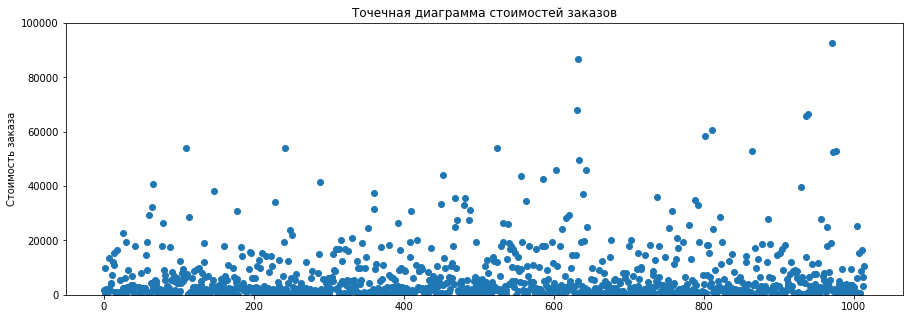

In [30]:
fig = plt.figure(figsize=(15, 5))
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ylabel('Стоимость заказа')
plt.title('Точечная диаграмма стоимостей заказов')
plt.ylim(0, 100000);

Похоже, что у большинства заказов сумма не превышает 40 тыс.руб., посмотрим, что покажут перцентили.

#### Определение аномальных заказов

Посчитаем выборочные перцентили стоимости заказов.

In [31]:
orders['revenue'].describe(percentiles=[0.95, 0.99])

count    1.016000e+03
mean     8.300815e+03
std      4.212199e+04
min      5.000000e+01
50%      2.955000e+03
95%      2.678500e+04
99%      5.390400e+04
max      1.294500e+06
Name: revenue, dtype: float64

Не более 5% заказов стоят более 27 тыс.руб. и не более 1% - более 54 тыс.руб.\
Будем считать аномальными заказы, стоимостью более 27 тыс.руб.

#### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя между группами по «сырым» данным — без удаления аномальных пользователей.\
Сформулируем гипотезы.\
*Нулевая:* различий в среднем количестве заказов между группами нет.\
*Альтернативная:* различия в среднем между группами есть.

Подготовим данные. 

In [32]:
# отбирем данные о покупателях за каждый день анализируемого периода в группе А
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# отбирем данные о покупателях за каждый день анализируемого периода в группе В
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# сгруппируем данные о покупках, совершенных в каждый день анализируемого периода в группе А
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

# сгруппируем данные о покупках, совершенных в каждый день анализируемого периода в группе В
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

# объединим все полученные данные в один датафрейм
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head())

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              23           142779              17   
1 2019-08-02              19            91602              23   
2 2019-08-03              24           112473              14   
3 2019-08-04              11            41176              14   
4 2019-08-05              22            86383              21   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0            59758                  23               142779   
1           162043                  42               234381   
2            67049                  66               346854   
3            96890                  77               388030   
4            89908                  99               474413   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  17                59758               719   
1                  40               221801               619   
2                  54               28

Названия столбцов в таблице:
- `date` — дата;
- `ordersPerDateA` — количество заказов в выбранную дату в группе A;
- `revenuePerDateA` — суммарная выручка в выбранную дату в группе A;
- `ordersPerDateB` — количество заказов в выбранную дату в группе B;
- `revenuePerDateB` — суммарная выручка в выбранную дату в группе B;
- `ordersCummulativeA` — суммарное число заказов до выбранной даты включительно в группе A;
- `revenueCummulativeA` — суммарная выручка до выбранной даты включительно в группе A;
- `ordersCummulativeB` — суммарное количество заказов до выбранной даты включительно в группе B;
- `revenueCummulativeB` — суммарная выручка до выбранной даты включительно в группе B;
- `visitorsPerDateA` — количество пользователей в выбранную дату в группе A;
- `visitorsPerDateB` — количество пользователей в выбранную дату в группе B;
- `visitorsCummulativeA` — количество пользователей до выбранной даты включительно в группе A;
- `visitorsCummulativeB` — количество пользователей до выбранной даты включительно в группе B.

Посчитаем статистическую значимость различия в среднем количестве заказов между группами.
Создадим переменные `ordersByUsersA` и `ordersByUsersB` со столбцами `['visitor_id', 'orders']`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [33]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

Объявим переменные `sampleA` и `sampleB`, в которых пользователям с заказами будет соответствовать число заказов пользователя. А пользователям без заказов — нули.\
Посчитаем статистическую значимость различия среднего количества заказов по результатам двух недель теста. Применим тест Манна-Уитни. 

In [34]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, \
index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, \
index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print('P-value:', "{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))
print('Относительное различие в среднем между группами:', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

if st.mannwhitneyu(sampleA, sampleB)[1] < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

P-value: 0.011
Относительное различие в среднем между группами: 0.160
Отвергаем нулевую гипотезу


P-value значительно меньше 0.05, поэтому нулевую гипотезу отвергаем.\
Анализ "сырых данных" сообщает, что в среднем количестве заказов между группами есть статистически значимые различия.\
Относительный прирост среднего группы В к конверсии группы А равен 16%.

#### Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

Теперь проверим статистическую значимость различий в среднем чеке между сегментами.\
*Нулевая гипотез:* различий в среднем чеке между группами нет.\
*Альтернативная гипотеза:* различия в среднем чеке между группами есть.\
Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию `mannwhitneyu()` данные о выручке с заказов.\
А ещё найдём относительные различия в среднем чеке между группами:

In [35]:
print('P-value:', '{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], \
                                                   orders[orders['group']=='B']['revenue'])[1]))
print('Относительный прирост среднего чека группы B:', \
      '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

if st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1] < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

P-value: 0.829
Относительный прирост среднего чека группы B: 0.287
Не получилось отвергнуть нулевую гипотезу


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. При этом, средний чек группы B значительно выше среднего чека группы A — относительное различие между группами 28.7%. Возможно, что причина такого прироста в выбросах, которые мы наблюдали ранее.

#### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Ранее за аномальных пользователей мы приняли тех, кто сделал более 2 заказов или совершил заказ дороже 27 тыс.руб. Так мы уберём 1% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 2 — `usersWithManyOrders` и пользователей, совершивших заказы дороже 27000 — `usersWithExpensiveOrders`. Объединим их в таблице `abnormalUsers`. 

In [36]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > int(np.percentile(ordersByUsersA['orders'], [99]))]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > int(np.percentile(ordersByUsersA['orders'], [99]))]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > int(np.percentile(orders['revenue'], [95]))]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head())
print('\n', 'Количество аномальных пользователей:', abnormalUsers.shape[0])

487    113298937
937    148427295
792    204675465
33     249864742
586    358944393
Name: visitor_id, dtype: int64

 Количество аномальных пользователей: 58


Всего 58 аномальных пользователей. 
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [37]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [38]:
print('P-value:', '{0:.3f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительное различие в среднем между группами:', \
      '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

if st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1] < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

P-value: 0.012
Относительное различие в среднем между группами: 0.182
Отвергаем нулевую гипотезу


Результаты по среднему количеству заказов практически не изменились, статистическая значимость достигнута. Группа В значительно лучше группы А.

#### Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

Посмотрим как изменились результаты по среднему чеку.

In [39]:
print('P-value:', 
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительный прирост среднего чека группы B:', 
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

if st.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A', \
                   np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'], \
                   orders[np.logical_and(orders['group'] == 'B', \
                   np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'])[1] < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

P-value: 0.646
Относительный прирост среднего чека группы B: -0.048
Не получилось отвергнуть нулевую гипотезу


P-value немного уменьшился по сравнению с "сырыми данными", но нулевую гипотезу по-прежнему не отвергаем. При этом после того, как из выборки убрали "выбросы", прирост среднего чека группы В относительно среднего чека группы А пропал и средний чек группы В даже стал немного меньше, чем средний чек группы А.

**Выводы по анализу A/B-теста**

- кумулятивная выручка по обеим группам растет на протяжении всего теста, однако в группе В наблюдается резкий "скачок" в районе 18 августа, который сигнализирует о наличии аномально дорогих заказах в выборке;
- кумулятиный средний чек в группе В выше, чем в группе А, что опять же является следствием зафиксированного "выброса";
- кумулятивная конверсия в группе В выше, чем в группе А;
- подавляющее большинство пользователей совершило один заказ, в связи с чем клиенты, совершившие более одного заказа были определены как аномальные;
- стоимость большинства заказов не превышает 27 тыс.руб., поэтому более дорогие заказы определили как аномальные;
- расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным показал, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы В к конверсии группы А равен 16%;
- расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным показал, что статистически значимых различий нет. При этом, средний чек группы B значительно выше среднего чека группы A — относительное различие между группами 28.7%;
- расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным показал практически такой же результат как по «сырым» данным;
- расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным также показал, что статистически значимых различий нет. При этом средний чек группы В потерял свое преимущество по сравнению со средним чеком группы А и даже стал немного меньше.

### Общие выводы и принятие решения по результатам теста

Подведем итоги проведенного исследования.

1. На начальном этапе исследования была проведена предобработка данных: проверили данные на наличие пропусков, явных дубликатов и аномалий. Были обнаружены пользователи, которые присутствовали одновременно в двух группах. Во избежание искажения результатов, пересекающиеся пользователи из выборки были исключены. Также для удобства анализа названия столбцов были приведены к "змеиному" регистру и у значений в столбцах с датой/временем тип данных поменяли на соответствующий.
2. Далее из 9 предоставленных гипотез посредством фреймворков ICE и RICE выбрали гипотезу "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" как приоритетную.
3. Проанализировав проведенный А/В-тест можно вывести основные тезисы:
- есть статистически значимые различия по среднему количеству заказов между группами и по "сырым", и по данным после фильтрации аномалий;
- нет статистически значимого различия по среднему чеку между группами ни по "сырым", ни по данным после фильтрации аномалий;
- график относительного различия кумулятивных конверсий показывает, что результаты группы B лучше группы A на порядка 16-18%;
- график различия среднего чека говорит о том, что результаты группы B лучше почти на 29%, но такой эффект был достигнут за счет "выбросов", а анализ "очищенных" данных показал, что средние чеки по группам практически не отличаются.
4. Исходя из вышеизложенного, тест следует остановить и признать победу группы В, но только в части конверсии.